In [ ]:
import os
import gc
from PIL import Image
import tensorflow
import shutil
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

sns.set()
np.random.seed(0);
tensorflow.random.set_seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_data = pd.read_csv('/content/content/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
from sklearn.model_selection import train_test_split
y = df_data['dx']
df_train, df_val = train_test_split(df_data, test_size=0.2, random_state=101, stratify=y)

In [ ]:
print(len(os.listdir('/content/content/base_dir/train_dir/nv')))
print(len(os.listdir('/content/content/base_dir/train_dir/mel')))
print(len(os.listdir('/content/content/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/content/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/content/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/content/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/content/base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


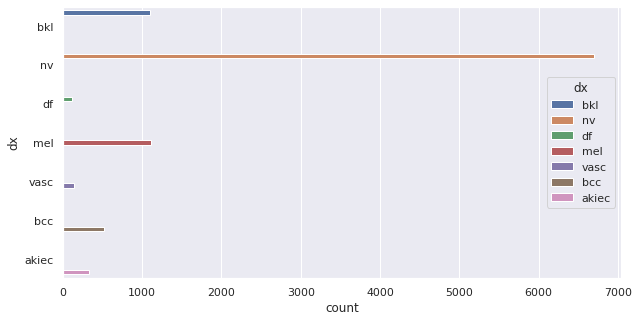

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='dx',data=df_data, hue="dx",ax=ax1)

In [ ]:
#Data Augmentation
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item
    img_list = os.listdir('/content/content/base_dir/train_dir/' + img_class)

    for fname in img_list:
            src = os.path.join('/content/content/base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = '/content/content/base_dir/train_dir/' + img_class

    # Data Generator 
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    num_aug_images_wanted = 6000 
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # Remove aug_dir
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [ ]:

print(len(os.listdir('/content/content/base_dir/train_dir/nv')))
print(len(os.listdir('/content/content/base_dir/train_dir/mel')))
print(len(os.listdir('/content/content/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/content/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/content/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/content/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/content/base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


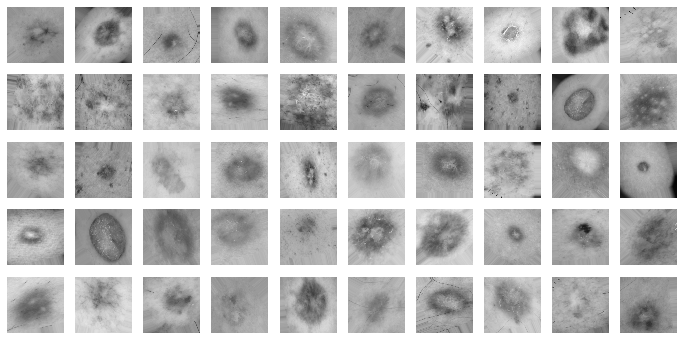

In [ ]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): 
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) 

In [ ]:

train_path = '/content/content/base_dir/train_dir'
valid_path = '/content/content/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

datagen = ImageDataGenerator(preprocessing_function= tensorflow.keras.applications.mobilenet.preprocess_input)
train_batches = datagen.flow_from_directory(train_path,
                                        target_size=(image_size,image_size),
                                        batch_size=train_batch_size)
val_batches = datagen.flow_from_directory(valid_path,
                                      target_size=(image_size,image_size),
                                      batch_size=val_batch_size)
test_batches = datagen.flow_from_directory(valid_path,
                                       target_size=(image_size,image_size),
                                       batch_size=1,
                                       shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [ ]:
model = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
len(model.layers)


93

In [ ]:
# CREATE THE MODEL

x = model.layers[-6].output
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
print(val_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
history = model.fit_generator(train_batches, steps_per_epoch=num_train_samples//train_batch_size, 
                              class_weight=class_weights,
                    validation_data=val_batches, 
                    epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
801/801 [==============================] - 34s 43ms/step - loss: 1.5612 - accuracy: 0.5401 - val_loss: 0.6144 - val_accuracy: 0.7996
Epoch 2/30
801/801 [==============================] - 34s 42ms/step - loss: 1.1677 - accuracy: 0.6411 - val_loss: 0.5076 - val_accuracy: 0.8177
Epoch 3/30
801/801 [==============================] - 34s 42ms/step - loss: 1.0359 - accuracy: 0.6806 - val_loss: 0.4811 - val_accuracy: 0.8486
Epoch 4/30
801/801 [==============================] - 34s 42ms/step - loss: 0.9577 - accuracy: 0.6970 - val_loss: 0.4583 - val_accuracy: 0.8475
Epoch 5/30
801/801 [==============================] - 33s 42ms/step - loss: 0.8814 - accuracy: 0.7223 - val_loss: 0.6834 - val_accuracy: 0.7452
Epoch 6/30
801/801 [==============================] - 33s 42ms/step - loss: 0.8228 - accuracy: 0.7434 - val_loss: 0.4239 - val_accuracy: 0.8731
Epoch 7/30
801/801 [==============================] - 33s 42

In [ ]:
print('Accuracy on test set:', model.evaluate(test_batches)[1])

938/938 [==============================] - 8s 9ms/step - loss: 0.5512 - accuracy: 0.8657
Accuracy on test set: 0.8656716346740723


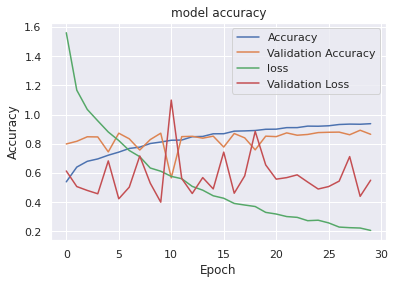

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
test_labels = test_batches.classes

In [ ]:

test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
predictions = model.predict_generator(test_batches, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
938/938 [==============================] - 7s 7ms/step


In [ ]:
predictions.shape

(938, 7)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(938,)

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 10   3   4   2   3   4   0]
 [  2  23   0   1   0   4   0]
 [  0   0  34   2   8  31   0]
 [  0   0   0   3   0   3   0]
 [  1   3   4   1  15  15   0]
 [  1   6   7   2  12 723   0]
 [  0   0   0   0   0   7   4]]


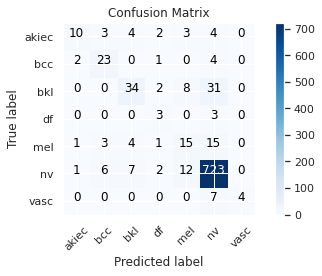

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [ ]:
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.71      0.38      0.50        26
         bcc       0.66      0.77      0.71        30
         bkl       0.69      0.45      0.55        75
          df       0.27      0.50      0.35         6
         mel       0.39      0.38      0.39        39
          nv       0.92      0.96      0.94       751
        vasc       1.00      0.36      0.53        11

    accuracy                           0.87       938
   macro avg       0.66      0.55      0.57       938
weighted avg       0.86      0.87      0.86       938



In [ ]:
model.save('appDermis_mobileNet.h5')